In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load_data
sampling_rate = 100  # Hz
duration = 10
fs = 100

data = np.load('/content/drive/MyDrive/Data/simu_0.1_90_180R.npy')
data_clean = np.load('/content/drive/MyDrive/Data/simu_0_90_180R.npy')
data_clean_NoRR = np.load('/content/drive/MyDrive/Data/simu_0_90_180_NoRR.npy')


labels, signals =  data[:, -6:], data[:, :1000]
signals_clean =  data_clean[:, :1000]
signals_clean_NoRR =  data_clean_NoRR[:, :1000]

In [5]:
!pip install EMD-signal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.0
    Uninstalling tqdm-4.66.0:
      Successfully uninstalled tqdm-4.66.0


**经验模态分解（EMD）**：
在EMD中，一个信号被分解成一组本征模态函数（IMF）。每个IMF满足以下条件：
1. 在信号的任何位置，极值点（局部最大值或局部最小值）的数目相等或相差最多一个。
2. 在信号的任何位置，局部平均值为零。

每轮迭代中，IMF的计算过程：
1. 找到信号的极值点（局部最大值和最小值）。
2. 对极值点之间的信号进行插值以获取上包络线和下包络线。
3. 计算平均包络线。
4. 从信号中减去平均包络线，得到一个称为局部振动模式（LVM）的IMF候选。
5. 如果LVM满足IMF的条件，则停止迭代，将其视为一个IMF。否则，将LVM作为原始信号进行新迭代。

**改进的经验模态分解（EEMD）**：
EEMD通过引入随机性来改进EMD，以解决模式混叠和陷阱问题。在EEMD中，每次迭代引入高斯白噪声，使得每次分解的结果略有不同。这些随机噪声有助于减少EMD中可能出现的问题，但需要多次重复分解以获得平均结果。


In [8]:
from PyEMD import EEMD, EMD

def standize(data):
    return (data - np.mean(data))/np.std(data)

def emd_decomposition(signal, noise_width=0.05, ensemble_size=100,emd_type=None, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)

    if emd_type is None:
      emd_type = 'emd'

    if emd_type == 'eemd':
      eemd = EEMD(trials=ensemble_size, noise_width=noise_width)
      imfs = eemd.eemd(signal)
    elif emd_type == 'emd':
      emd = EMD()
      imfs = emd(signal)

    print(imfs.shape)

    return imfs


(8, 1000)


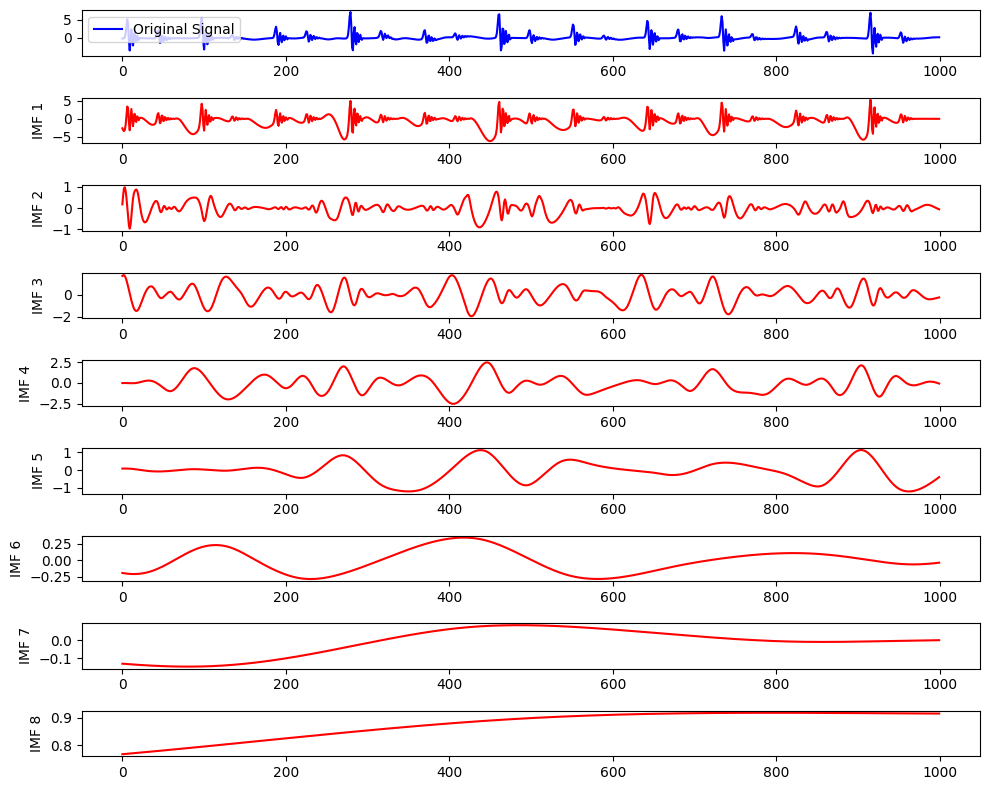

(10, 1000)


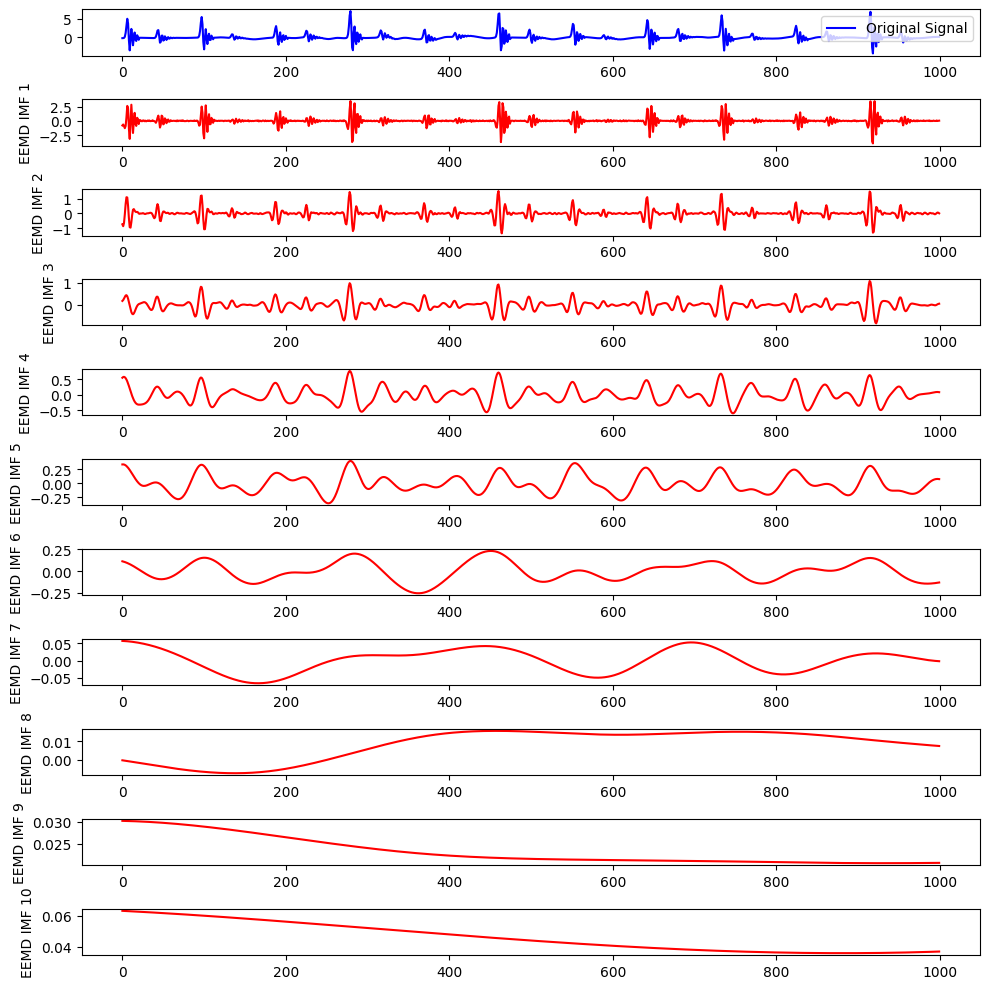

In [16]:
# 绘制EMD结果
signal = signals[np.random.randint(0, 300)]
signal = standize(signal)

imfs_emd = emd_decomposition(signal, emd_type='emd')

plt.figure(figsize=(10, 1 * len(imfs_emd)))
plt.subplot(len(imfs_emd)+1, 1, 1)
plt.plot(signal, 'b', label='Original Signal')
plt.legend()

for i, imf in enumerate(imfs_emd):
    plt.subplot(len(imfs_emd)+1, 1, i+2)
    plt.plot(imf, 'r')
    plt.ylabel(f'IMF {i+1}')

plt.tight_layout()
plt.show()

imfs_eemd = emd_decomposition(signal, emd_type='eemd')

# 绘制EEMD结果
plt.figure(figsize=(10, 1 * len(imfs_eemd)))
plt.subplot(len(imfs_eemd)+1, 1, 1)
plt.plot(signal, 'b', label='Original Signal')
plt.legend()

for i in range(len(imfs_eemd)):
    plt.subplot(len(imfs_eemd)+1, 1, i+2)
    plt.plot(imfs_eemd[i], 'r')
    plt.ylabel(f'EEMD IMF {i+1}')

plt.tight_layout()
plt.show()
